# Домашнее задание 2.1. Сверточные сети



В этом задании вы должны:
1. Написать слой Conv2d на Numpy и определить в нем forward-backward методы
2. Определить слой MaxPool2d
3. Написать всю необходимую обвязку для обучения: оптимизатор с адаптивным шагом и класс, позволяющий изменять расписание для learning rate'а



> Обратите внимание, что в этом задании больше нет тестов.
> Вы должны сами проверять свой код.  
> Это можно сделать так:
> 1. Написать юнит-тесты с помощью Pytorch. То есть, ваш модудь должен повторять поведение torch'а
> 2. Проверять архитектуру не на всем датасете, а на подвыборке: при наивной имплементации слоев одна эпоха на всем датасете будет занимать около двух часов

## Numpy-имплементация сверточной нейронной сети


Вставьте сюда имплементацию из первого домашнего задания.



> Обратите внимание, что обновление весов теперь производится с помощью специального класса **Optimizer**



In [16]:
import os
import sys
import numpy as np

def load_mnist(flatten=False):
    """taken from https://github.com/Lasagne/Lasagne/blob/master/examples/mnist.py"""
    # We first define a download function, supporting both Python 2 and 3.
    if sys.version_info[0] == 2:
        from urllib import urlretrieve
    else:
        from urllib.request import urlretrieve

    def download(filename, source='https://ossci-datasets.s3.amazonaws.com/mnist/'):
        print("Downloading %s" % filename)
        urlretrieve(source + filename, filename)

    # We then define functions for loading MNIST images and labels.
    # For convenience, they also download the requested files if needed.
    import gzip

    def load_mnist_images(filename):
        if not os.path.exists(filename):
            download(filename)
        # Read the inputs in Yann LeCun's binary format.
        with gzip.open(filename, 'rb') as f:
            data = np.frombuffer(f.read(), np.uint8, offset=16)
        # The inputs are vectors now, we reshape them to monochrome 2D images,
        # following the shape convention: (examples, channels, rows, columns)
        data = data.reshape(-1, 1, 28, 28)
        # The inputs come as bytes, we convert them to float32 in range [0,1].
        # (Actually to range [0, 255/256], for compatibility to the version
        # provided at http://deeplearning.net/data/mnist/mnist.pkl.gz.)
        return data / np.float32(256)

    def load_mnist_labels(filename):
        if not os.path.exists(filename):
            download(filename)
        # Read the labels in Yann LeCun's binary format.
        with gzip.open(filename, 'rb') as f:
            data = np.frombuffer(f.read(), np.uint8, offset=8)
        # The labels are vectors of integers now, that's exactly what we want.
        return data

    # We can now download and read the training and test set images and labels.
    X_train = load_mnist_images('train-images-idx3-ubyte.gz')
    y_train = load_mnist_labels('train-labels-idx1-ubyte.gz')
    X_test = load_mnist_images('t10k-images-idx3-ubyte.gz')
    y_test = load_mnist_labels('t10k-labels-idx1-ubyte.gz')

    # We reserve the last 10000 training examples for validation.
    X_train, X_val = X_train[:-10000], X_train[-10000:]
    y_train, y_val = y_train[:-10000], y_train[-10000:]

    if flatten:
        X_train = X_train.reshape([X_train.shape[0], -1])
        X_val = X_val.reshape([X_val.shape[0], -1])
        X_test = X_test.reshape([X_test.shape[0], -1])

    # We just return all the arrays in order, as expected in main().
    # (It doesn't matter how we do this as long as we can read them again.)
    return X_train, y_train, X_val, y_val, X_test, y_test

In [3]:
class Layer:
    """
    A building block. Each layer is capable of performing two things:

    - Process input to get output:           output = layer.forward(input)

    - Propagate gradients through itself:    grad_input = layer.backward(input, grad_output)

    Some layers also have learnable parameters which they update during layer.backward.
    """
    def __init__(self):
        """Here you can initialize layer parameters (if any) and auxiliary stuff."""
        pass

    def forward(self, input):
        """
        Takes input data of shape [batch, input_units], returns output data [batch, output_units]
        """
        return input

    def backward(self, input, grad_output):
        """
        Performs a backpropagation step through the layer, with respect to the given input.

        To compute loss gradients w.r.t input, you need to apply chain rule (backprop):

        d loss / d x  = (d loss / d layer) * (d layer / d x)

        Luckily, you already receive d loss / d layer as input, so you only need to multiply it by d layer / d x.

        If your layer has parameters (e.g. dense layer), you also need to update them here using d loss / d layer
        """
        input_dim = input.shape[1]

        d_layer_d_input = np.eye(input_dim)

        return np.dot(grad_output, d_layer_d_input) # chain rule

In [4]:
class ReLU(Layer):
    def __init__(self):
        """ReLU layer simply applies elementwise rectified linear unit to all inputs"""
        pass

    def forward(self, input):
        """Apply elementwise ReLU to [batch, input_units] matrix"""
        output = np.array(input)
        output[output < 0] = 0
        return output

    def backward(self, input, grad_output):
        """Compute gradient of loss w.r.t. ReLU input"""
        relu_grad_mask = np.zeros_like(input)
        relu_grad_mask[input > 0] = 1
        return grad_output * relu_grad_mask

In [5]:
class Dense(Layer):
    def __init__(self, input_units, output_units, learning_rate=0.1):
        """
        A dense layer is a layer which performs a learned affine transformation:
        f(x) = <W*x> + b
        """
        self.learning_rate = learning_rate

        # initialize weights with small random numbers from normal distribution
        # you can change the intializtion method
        self.weights = np.random.randn(input_units, output_units)*0.01
        self.biases = np.zeros(output_units)

    def forward(self,input):
        """
        Perform an affine transformation:
        f(x) = <W*x> + b

        input shape: [batch, input_units]
        output shape: [batch, output_units]
        """
        return np.dot(input, self.weights) + self.biases

    def backward(self, input, grad_output):

        # compute d f / d x = d f / d dense * d dense / d x
        # where d dense/ d x = weights transposed
        # grad_output is a derivative of the next (in forward) layer of prediction
        # this result is needed for the next layer
        grad_input = np.dot(grad_output, np.transpose(self.weights))

        # compute gradient w.r.t. weights and biases
        grad_weights = np.dot(np.transpose(input), grad_output)
        grad_biases = np.sum(grad_output, axis=0)

        # Gradient step should be performed with the help of separate optimizer
        assert grad_weights.shape == self.weights.shape and grad_biases.shape == self.biases.shape
        return grad_input

In [6]:
class Conv2d(Layer):
    def __init__(self, input_channels, output_channels, kernel_size, learning_rate=0.1):
        self.weights = np.random.randn(input_channels, output_channels, kernel_size, kernel_size)*0.01
        self.biases = np.zeros(output_channels)

        self.learning_rate = learning_rate
        
        self.grad_weights = None
        self.grad_biases = None

    def _conv(input, weights, biases):
        kernel_height = np.shape(weights)[2]
        kernel_width = np.shape(weights)[3]
        output_chanels = np.shape(weights)[1]
        # Output dimention is determined by the number of filters in the layer.
        # Each filter is a tensor with the size (input_channels, kernel_size, kernel_size)
        # (In this example second axis is an index of filter)
        # Such a filter produces one number per convolution 
        #   and this convolution is performed for each part of the input tensor.
        batch_size = np.shape(input)[0]
        output_height = np.shape(input)[2] - kernel_height + 1
        output_width = np.shape(input)[3] - kernel_width + 1

        # This is the result of convollution of each filter
        filters = np.empty((output_chanels, output_height, output_width, batch_size))
        for filter_idx in range(output_chanels):
            for i in range(output_height):
                for j in range(output_width):
                    filters[filter_idx, i, j] = \
                        np.tensordot(input[:, :, i:i+kernel_height, j:j+kernel_width],
                                     weights[:, filter_idx, :, :],
                                     axes=([1, 2, 3], [0, 1, 2]))
        output = np.rollaxis(filters, 3, 0)
        if biases is not None:
        # Here values from biases are broadcasted
            output += np.reshape(biases, (1, output_chanels, 1, 1))
        return output

    def _pad(tensor, val, new_height, new_width):
        pad_h = (new_height - np.shape(tensor)[2]) // 2
        pad_w = (new_width - np.shape(tensor)[3]) // 2
        padding = ((0, 0), (0, 0), (pad_h, pad_h), (pad_w, pad_w))
        res = np.pad(tensor, padding, 'constant', constant_values=(val, val))
        assert np.shape(res)[2] == new_height and np.shape(res)[3] == new_width
        return res
    
    def _flip_transpose(tensor):
        tensor = np.flip(tensor, (2, 3))
        tensor = np.moveaxis(tensor, 2, 3) # this should work
        return tensor

    def forward(self, input):
        """
        Perform an convolution:

        output_height = input_height - kernel_size + 1
        output_width = input_width - kernel_size + 1

        input shape: [batch, input_channels, input_height, input_width]
        output shape: [batch, output_channels, output_height, output_width]
        """
        return Conv2d._conv(input, self.weights, self.biases)
        

    def backward(self, input, grad_output):
        # Grad output has the shape [batch, output_channels, output_height, output_width]
        # I don't know how this is possible, but if has these axises, convolution just works
        input = np.moveaxis(input, 0, 1)
        grad_weights = Conv2d._conv(input, grad_output, None)
        input = np.moveaxis(input, 0, 1)
        # dldb = dldz * dzdb 
        # dzdb = 1
        # dldz = grad_output
        # Each biases' component is applied to each element with the fixed output_chanels axis,
        #   so input gradient is the sum of all output gradients
        grad_biases = np.sum(grad_output, axis=(0, 2, 3))

        kernel_size = np.shape(self.weights)[2]
        # Probably I shouldn't change input tensor, but whatever
        grad_padded = Conv2d._pad(grad_output, 0,
                                   np.shape(input)[2] + kernel_size - 1,
                                   np.shape(input)[3] + kernel_size - 1)
        tmp_weights = np.copy(self.weights)
        tmp_weights = Conv2d._flip_transpose(tmp_weights)
        tmp_weights = np.moveaxis(tmp_weights, 0, 1)
        grad_input = Conv2d._conv(grad_padded, tmp_weights, None)

        # Gradient step is in a separate optimizer
        assert grad_weights.shape == self.weights.shape and grad_biases.shape == self.biases.shape
        return grad_input

In [7]:
# Conv2D test
from torch import nn
import torch
test_batch_size = 10
test_input_chanels = 3
test_output_chanels = 2
test_input_height = 4
test_input_width = 5
test_kernel_size = 2

test_conv = Conv2d(input_channels=test_input_chanels, 
                   output_channels=test_output_chanels, 
                   kernel_size=test_kernel_size)
test_input = np.random.randn(test_batch_size, 
                             test_input_chanels, 
                             test_input_height,
                             test_input_width)
test_output = test_conv.forward(test_input)
test_layer_torch = nn.Conv2d(in_channels=test_input_chanels,
                     out_channels=test_output_chanels,
                     kernel_size=(test_kernel_size, test_kernel_size))
test_ref = test_layer_torch(torch.tensor(test_input, dtype=torch.float))
print("Test shapes:")
print(test_ref.shape)
print(test_output.shape)
#assert torch.equal(torch.tensor(test_output, dtype=torch.float), test_ref)


Test shapes:
torch.Size([10, 2, 3, 4])
(10, 2, 3, 4)


In [8]:
print(f"Input shapes {np.shape(test_input)}, {np.shape(test_output)}")
test_conv.backward(test_input, test_output)

Input shapes (10, 3, 4, 5), (10, 2, 3, 4)


array([[[[-9.51866913e-04, -7.50838179e-04, -1.08698607e-03,
          -4.29527551e-04, -1.69690940e-04],
         [ 8.12572149e-04,  1.89395250e-04, -5.97774487e-04,
          -1.63375913e-03, -5.05891268e-04],
         [ 3.12043490e-04, -3.52872669e-04, -4.84598210e-04,
           8.52907876e-04,  6.44280115e-04],
         [-3.03319331e-04, -1.98457861e-04, -4.44630827e-04,
          -4.88709446e-04, -8.38695337e-05]],

        [[ 3.33523910e-04, -4.54835279e-04,  2.81424518e-04,
          -1.77954190e-04,  2.68280151e-05],
         [ 6.14554804e-04,  1.18382402e-04,  1.01605212e-03,
           5.73653102e-04, -2.70644959e-04],
         [-4.74880466e-04, -1.48189113e-04, -8.30828126e-05,
           6.22928985e-04, -3.30373493e-04],
         [-5.46758854e-05,  5.98579951e-04,  3.27410142e-04,
           1.42447359e-04,  7.25808815e-05]],

        [[ 1.36393793e-04,  8.69183435e-05,  3.50690931e-04,
           2.16972803e-04,  1.19644437e-04],
         [-3.21596617e-04, -6.74621171e-04

In [9]:
class MaxPool2d(Layer):
    def __init__(self, kernel_size):
        self.kernel_size = kernel_size
        self.max_elem_mask = None

    def forward(self, input):
        """
        Perform an pooling:

        output_height = input_height // kernel_size
        output_width = input_width // kernel_size

        input shape: [batch, input_channels, input_height, input_width]
        output shape: [batch, input_channels, output_height, output_width]
        """
        type = input.dtype
        kernel_size = self.kernel_size
        batch = np.shape(input)[0]
        input_chanels = np.shape(input)[1]
        output_height = np.shape(input)[2]
        output_width = np.shape(input)[3]
        output = np.empty((output_height, output_width, batch, input_chanels))
        self.max_elem_mask = np.empty((batch, input_chanels, np.shape(input)[2], np.shape(input)[3]))
        for i in range(output_height):
            for j in range(output_width):
                input_slice = input[:, :, i:i+kernel_size, j:j+kernel_size]
                max_tensor = np.max(input_slice, axis=(2, 3))
# How should I handlel such indexes convertions???????
                output[i, j] = max_tensor
                self.max_elem_mask[:, :, i:i+kernel_size, j:j+kernel_size] = \
                    np.equal(input_slice, np.reshape(max_tensor, 
                                                     (np.shape(max_tensor)[0],
                                                      np.shape(max_tensor)[1],
                                                     1, 1)))
        return np.moveaxis(output, [0, 1], [2, 3])

    def backward(self, input, grad_output):
        type = input.dtype
        kernel_size = self.kernel_size
        grad_input = self.max_elem_mask
        for i in range(np.shape(grad_output)[2]):
            for j in range(np.shape(grad_output)[3]):
                grad_input[:, :, i:i+kernel_size, j:j+kernel_size] = \
                    np.multiply(grad_output[:, :, i:i+1, j:j+1], 
                                self.max_elem_mask[:, :, i:i+kernel_size, j:j+kernel_size],
                                dtype=type)
        self.max_elem_mask = None
        return grad_input

In [10]:
test_maxpool = MaxPool2d(2)
test_output = test_maxpool.forward(test_input)
print(np.shape(test_maxpool.max_elem_mask))
test_backward = test_maxpool.backward(test_input, test_output)
print(f"input_shape {np.shape(test_input)} grad shape: {np.shape(test_backward)}")

(10, 3, 4, 5)
input_shape (10, 3, 4, 5) grad shape: (10, 3, 4, 5)


In [41]:
class Flatten(Layer):
    def forward(self, input):
          """
          Perform an flatten operation:

          input shape: [batch, input_channels, input_height, input_width]
          output shape: [batch, input_channels * output_height * output_width]
          """
          flattened_size = np.shape(input)[1] * np.shape(input)[2] * np.shape(input)[3]
          return np.reshape(input, (np.shape(input)[0], flattened_size))

    def backward(self, input, grad_output):
        return np.reshape(grad_output, np.shape(input))

In [42]:
def softmax_crossentropy_with_logits(logits,reference_answers):
    """Compute crossentropy from logits[batch,n_classes] and ids of correct answers"""
    logits_for_answers = logits[np.arange(len(logits)),reference_answers]

    xentropy = - logits_for_answers + np.log(np.sum(np.exp(logits),axis=-1))

    return xentropy

def grad_softmax_crossentropy_with_logits(logits,reference_answers):
    """Compute crossentropy gradient from logits[batch,n_classes] and ids of correct answers"""
    ones_for_answers = np.zeros_like(logits)
    ones_for_answers[np.arange(len(logits)),reference_answers] = 1

    softmax = np.exp(logits) / np.exp(logits).sum(axis=-1,keepdims=True)

    return (- ones_for_answers + softmax) / logits.shape[0]

## Имплементация оптимизатора и изменения learning rate'a

В имплементации этих двух классов есть небольшие неточности.
Посмотрите, как сделана имплементация метода моментов в Pytorch и добавьте пропущенное.

> Добавлять моменты Нестерова не нужно!



In [66]:
class SGDOptimizer:
    def __init__(self, momentum=0.9, dampening=0.0, weight_decay=0.0):
        """
        Wrapper which perfoms weights update
        """
        self.momentum = momentum
        self.dampening = dampening
        self.weight_decay = weight_decay

        self.momentum_buffer = None

    def step(self, weights, grad_weights, lr=0.1):
        """
        Update weights
        """
        # For no there is no input parameter
        #if self.weight_decay != 0:
        #  grad_weights = grad_weights + self.weight_decay * input

        if self.momentum != 0:
            if self.momentum_buffer is None:
                self.momentum_buffer = grad_weights
            else:
                self.momentum_buffer = self.momentum * self.momentum_buffer + \
                                    (1 - self.dampening) * grad_weights
            grad_weights = self.momentum_buffer
      
        return weights - lr * self.momentum_buffer

In [69]:
class LRScheduler:
    def __init__(self, lr):
        """
        Wrapper which perfoms learning rate updates
        """
        self.lr = lr
        self.current_step = 0

    def get_lr(self):
      """
      Update learing rate for current iteration
      """
      current_lr = self.lr / (self.current_step + 1)
      #<your code here>
      self.current_step += 1
      return current_lr

    def reset(self):
       self.current_step = 0

## Итоговая нейросеть

Все готово для запуска нейросети. Нейросеть будем тестировать на классическом датасете MNIST. Код ниже визуализирует несколько примеров из этого датасета.

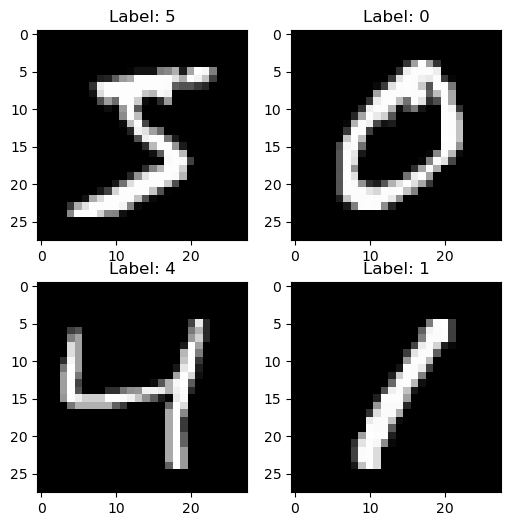

In [70]:
import matplotlib.pyplot as plt
%matplotlib inline

X_train, y_train, X_val, y_val, X_test, y_test = load_mnist(flatten=False)

plt.figure(figsize=[6,6])
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.title("Label: %i"%y_train[i])
    plt.imshow(X_train[i].reshape([28,28]),cmap='gray');

В нашей реализации сеть - просто список (Python-list) слоев.



> Обратите внимание, что у нас нет глобального пулинга. При изменении архитектуры сети вы должны поменять входую размерность в последнем Dense слое



In [71]:
network = []
network.append(Conv2d(1, 4, 5))
network.append(MaxPool2d(2))
network.append(ReLU())
network.append(Conv2d(4, 8, 5))
network.append(MaxPool2d(2))
network.append(ReLU())
network.append(Flatten())
network.append(Dense(3200, 10))

In [72]:
learning_rate = 0.1

optimizer = SGDOptimizer()
scheduler = LRScheduler(learning_rate)

Реализуйте прямой проход по целой сети, последовательно вызывая .forward() для каждого слоя.

In [73]:
def forward(network, X):
    """
    Compute activations of all network layers by applying them sequentially.
    Return a list of activations for each layer.
    Make sure last activation corresponds to network logits.
    """
    activations = []
    input = X

    for layer in network:
        input = layer.forward(input)
        activations.append(input)

    assert len(activations) == len(network)
    return activations

def predict(network, X):
    """
    Use network to predict the most likely class for each sample.
    """
    logits = forward(network, X)[-1]
    return logits.argmax(axis=-1)

In [74]:
def train(network, X, y, optimizer, scheduler):
   """
   Train your network on a given batch of X and y.
   You first need to run forward to get all layer activations.
   Then you can run layer.backward going from last to first layer.

   After you called backward for all layers, all Dense layers have already made one gradient step.
   """

   # Get the layer activations
   layer_activations = forward(network,X)
   layer_inputs = [X] + layer_activations  #layer_input[i] is an input for network[i]
   logits = layer_activations[-1]

   # Compute the loss and the initial gradient
   loss = softmax_crossentropy_with_logits(logits,y)
   loss_grad = grad_softmax_crossentropy_with_logits(logits,y)

   gradients = []
   for i in range(0, len(network)):
      cur_pos = len(network) - 1 - i
      gradients.append(loss_grad)
      loss_grad = network[cur_pos].backward(layer_inputs[cur_pos], loss_grad)

   # update weights and biases with optimizer
   for i in range(0, len(network)):
      cur_pos = len(network) - 1 - i
      grad_weights = gradients[i]
      lr = scheduler.get_lr()
      optimizer.step(network[cur_pos].weights, grad_weights, lr)

   # update learning rate
   #<YOUR CODE>

   return np.mean(loss)

Все готово для запуска обучения. Если все реализовано корректно, то точность классификации на валидационном множестве **должна быть около** 99%.

In [75]:
from tqdm.auto import tqdm
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.random.permutation(len(inputs))
    for start_idx in tqdm(range(0, len(inputs) - batchsize + 1, batchsize)):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

In [76]:
from IPython.display import clear_output
train_log = []
val_log = []

In [77]:
for epoch in range(15):

    for x_batch,y_batch in iterate_minibatches(X_train, y_train, batchsize=32, shuffle=True):
        train(network, x_batch, y_batch, optimizer, scheduler)

    train_log.append(np.mean(predict(network, X_train) == y_train))
    val_log.append(np.mean(predict(network, X_val) == y_val))

    clear_output()
    print("Epoch",epoch)
    print("Train accuracy:",train_log[-1])
    print("Val accuracy:",val_log[-1])
    plt.plot(train_log,label='train accuracy')
    plt.plot(val_log,label='val accuracy')
    plt.legend(loc='best')
    plt.grid()
    plt.show()


  0%|          | 0/1562 [00:00<?, ?it/s]

ValueError: operands could not be broadcast together with shapes (3200,10) (32,10) 